## Week 5 Assignment of Applied Data Science Capstone
### Capstone Project - The Battle of Neighborhoods (Week 2)

# Explore and analyze rents and venues regarding relocating and house-hunting in Berlin, Germany

### Before we get the data and start exploring and analyze it, let's download all the dependencies that we will need and import initial libraries.

In [1]:
!conda install -c conda-forge curl --yes
!conda install -c conda-forge geojson --yes
!conda install -c conda-forge geocoder --yes

import json
import pandas as pd
import numpy as np

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns
from bs4 import BeautifulSoup

import re
import requests

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model

from scipy.spatial.distance import cdist

import geocoder
from geopy.geocoders import Nominatim

%matplotlib inline

print('Dependencies in place and set up.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Dependencies in place and set up.


### Getting data on Berlin neighborhoods

There are 12 neighborhoods in Berlin. We'll use label `Boroughs` to identify them.
In my initial dataframe we'll download geojson file with Polygon, latitude and longitude coordinates data in geojson format from GitHub repo https://data.technologiestiftung-berlin.de/data/bezirksgrenzen/bezirksgrenzen.geojson shape file. 
We will also use borough names from the same file.

Data is simplified version of `https://data.technologiestiftung-berlin.de/data/bezirksgrenzen/bezirksgrenzen.geojson`

In [2]:
#!curl https://data.technologiestiftung-berlin.de/data/bezirksgrenzen/bezirksgrenzen.geojson --output berlin-bezirksgrenzen.geojson --silent
!curl https://raw.githubusercontent.com/srdansuka/BerlinBoroughs/master/berlin-bezirksgrenzen.geojson --output berlin-bezirksgrenzen.geojson --silent

In [3]:
!python geojson_utils.py

In [4]:
from geojson_utils import centroid
import geojson
from pprint import pprint, pformat
columns = ["ID", "Borough", "Latitude","Longitude"]
rows = []

with open('berlin-bezirksgrenzen.geojson', encoding='utf-8') as json_file:
    data = json.load(json_file)
    for f in data['features']:  
        box_str = f['geometry']
        centroid_data = centroid(box_str)
        rows.append((f['properties']['Gemeinde_schluessel'], f['properties']['Gemeinde_name'], centroid_data['coordinates'][1],centroid_data['coordinates'][0]))

rows = sorted(rows, key=lambda rows: rows[0])
berlin_df = pd.DataFrame(rows, columns=columns)
berlin_df

,ID,Borough,Latitude,Longitude
0,01,Mitte,52.532895,13.365970
1,02,Friedrichshain-Kreuzberg,52.503811,13.428234
2,03,Pankow,52.597229,13.440279
3,04,Charlottenburg-Wilmersdorf,52.501039,13.270249
4,05,Spandau,52.525791,13.178819
5,06,Steglitz-Zehlendorf,52.434843,13.239075
6,07,Tempelhof-Schöneberg,52.441117,13.380739
7,08,Neukölln,52.441082,13.454965
8,09,Treptow-Köpenick,52.429583,13.611210
9,10,Marzahn-Hellersdorf,52.521121,13.578832


### Visualize Berlin neighborhoods on map

On the following Folium map, all 12 boroughs are marked with blue circle.

In [5]:
berlin_coords = geocoder.arcgis('{}, Berlin, Germany'.format('')).latlng
print('The geograpical coordinate of Berlin, Germany are {}, {}.'.format(berlin_coords[0], berlin_coords[1])) 

map_berlin = folium.Map(location=[berlin_coords[0], berlin_coords[1]], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(berlin_df['Latitude'], berlin_df['Longitude'], berlin_df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_berlin)

map_berlin

The geograpical coordinate of Berlin, Germany are 52.51604000000003, 13.376910000000066.


## Explore and make database of apartments for rent in Berlin

Dataset was scraped from https://www.wohnungsboerse.net/mietspiegel-Berlin/2825 with data of July, 2019 

In [6]:
berlin_apartments_rentals_columns = ["Borough", "AvgPrice_€m2"]
berlin_apartments_rentals_rows = [
("Mitte", 20.18),
("Friedrichshain-Kreuzberg", 14.89),
("Pankow", 11.59),
("Charlottenburg-Wilmersdorf", 14.47),
("Spandau", 12.298),
("Steglitz-Zehlendorf", 12.58),
("Tempelhof-Schöneberg", 11.95),
("Neukölln", 13.88),
("Treptow-Köpenick", 12.15),
("Marzahn-Hellersdorf", 9.29),
("Lichtenberg", 12.98),
("Reinickendorf", 10.87)
]
berlin_apartments_rentals_df = pd.DataFrame(berlin_apartments_rentals_rows, columns=berlin_apartments_rentals_columns)
berlin_apartments_rentals_df["Borough"].tolist()

['Mitte',
 'Friedrichshain-Kreuzberg',
 'Pankow',
 'Charlottenburg-Wilmersdorf',
 'Spandau',
 'Steglitz-Zehlendorf',
 'Tempelhof-Schöneberg',
 'Neukölln',
 'Treptow-Köpenick',
 'Marzahn-Hellersdorf',
 'Lichtenberg',
 'Reinickendorf']

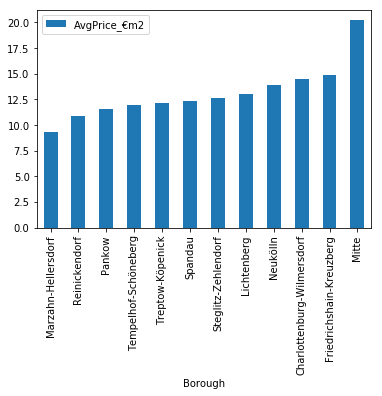

In [7]:
%matplotlib inline
berlin_apartments_rentals_df.sort_values(by="AvgPrice_€m2", ascending=True).set_index("Borough").plot.bar()

Looking at the graph, we can see that avg rental prices are more then double when we compare the most expensive Mitte (Berlin center) has the highest (20.18 €/m2) to Marzahn-Hellersdorf with (9.29 €/m2)

### Historical analysis of rent prices

In [8]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

page = requests.get("https://www.wohnungsboerse.net/mietspiegel-Berlin/2825")
soup = BeautifulSoup(page.content, 'lxml')
for script in soup(["script"]):
    script.extract()
    
rents_berlin_2019 = soup.find(text='Mietpreisspiegel für Mietwohnungen 2019').findNext("table")
rents_berlin_2019_columns = ["square_m", "Berlin", "Germany"]
rents_berlin_2019_rows = []

for tr in rents_berlin_2019.find("tbody").findAll("tr"):
    m2 = tr.findChildren()[0].text.strip()
    m2 = re.sub('[^0-9]','', m2)
    be = float(tr.findChildren()[1].text.strip('€').replace(",",".").strip())
    ge = float(tr.findChildren()[3].text.strip('€').replace(",",".").strip())
    rents_berlin_2019_rows.append((m2,be,ge))
    
rents_berlin_2019_df = pd.DataFrame(rents_berlin_2019_rows, columns=rents_berlin_2019_columns)
rents_berlin_2019_df



,square_m,Berlin,Germany
0,30,13.80,11.63
1,60,11.46,7.94
2,100,13.07,9.32


### Comparison of rental prices in Berlin vs rest of Germany

Comparison is made with data from July 2019. Prices are in €/m2 and are done in 3 categories of apartment sizes, 30, 60 and 100 m2.

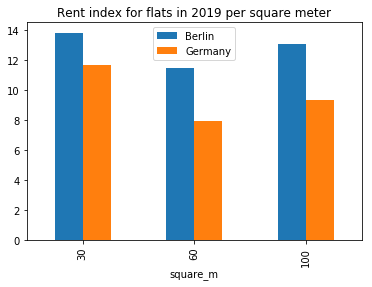

In [9]:
rents_berlin_2019_df.set_index("square_m").plot.bar(title="Rent index for flats in 2019 per square meter")

Looking at the graph, we can conclude that the Belin is very expensive compared to the rest of Germany

### Price trendline as of 2011

In [10]:
rents_berlin_2011_2018 = soup.find(text='Mietpreise Vergleich im Jahr 2011 - 2018').findNext("table")
rents_berlin_2011_2018_columns = ['square_m', 'Year', 'Rent']
rents_berlin_2011_2018_rows = []

current_square = 0
for tr in rents_berlin_2011_2018.find("tbody").findAll("tr"):
    if len(tr.findChildren()) == 1:
        # We found beginning of new square meter section
        current_square = re.sub('[^0-9]','', tr.findChildren()[0].text)
        continue
        
    ye = int(tr.findChildren()[0].text.strip())
    be = float(tr.findChildren()[1].text.strip('€').replace(",",".").strip())
    
    rents_berlin_2011_2018_rows.append((current_square,ye,be))
                
rents_berlin_2011_2018_df = pd.DataFrame(rents_berlin_2011_2018_rows, columns=rents_berlin_2011_2018_columns)

In [11]:
rents_berlin_2011_2018_df

,square_m,Year,Rent
0,30,2011,8.36
1,30,2012,9.02
2,30,2013,10.08
3,30,2014,11.06
4,30,2015,11.55
5,30,2016,14.25
6,30,2017,12.04
7,30,2018,13.93
8,60,2011,6.17
9,60,2012,6.74


In [12]:
rental_prices_2019 = rents_berlin_2019_df[["square_m", "Berlin"]].copy(deep=True)
rental_prices_2019.rename({"Berlin":"Rent"}, inplace=True,axis=1)
rental_prices_2019.insert(loc=1, column="Year", value=2019)

rental_prices_2019

,square_m,Year,Rent
0,30,2019,13.80
1,60,2019,11.46
2,100,2019,13.07


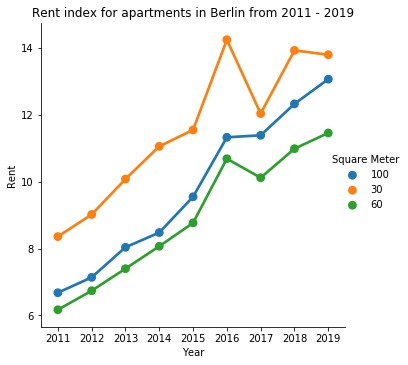

In [15]:
combined_data = pd.concat([rents_berlin_2011_2018_df,rental_prices_2019], sort=False).reset_index()
rents_berlin_2011_2018_plot = sns.catplot(x="Year", y="Rent", hue="square_m", kind="point", data=combined_data,legend_out=True)
rents_berlin_2011_2018_plot._legend.set_title("Square Meter")
plt.title('Rent index for apartments in Berlin from 2011 - 2019',size=12)

plt.show()

If we check this graph we can conclude that during last 8 years, prices have dubled, and are rising almost linearly.

## Explore and make database of vanues and social events in Berlin

In [16]:
CLIENT_ID = 'A35B5FCM53IJWUGD3N4VH5L5KJNUO1QUE5QQBROYESIRAMER' # your Foursquare ID
CLIENT_SECRET = 'WFFBIXBT2XU0QIZEKRECXJADHUPN3TRFT5U3RQGICCRTNLMN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Explore Berlin neighborhoods for venus using FourSquare API

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### We will search for 100 venues in radius of 1.5 km

In [18]:
berlin_venues = getNearbyVenues(berlin_df['Borough'], berlin_df['Latitude'], berlin_df['Longitude'])
print("Our venues dataset includes", berlin_venues.shape[0], 'venues, each has', berlin_venues.shape[1], 'attributes')
print('There are', len(berlin_venues['Venue Category'].unique()), 'categories in total')
berlin_venues.head()

Our venues dataset includes 611 venues, each has 7 attributes
There are 184 categories in total


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mitte,52.532895,13.36597,CrossFit Mitte,52.530926,13.367450,Gym / Fitness Center
1,Mitte,52.532895,13.36597,Bata Bar & Billiards,52.530414,13.367150,Pool Hall
2,Mitte,52.532895,13.36597,Uferpromenade Berlin-Spandauer-Schifffahrtskanal,52.533869,13.368787,Trail
3,Mitte,52.532895,13.36597,Filmrauschpalast,52.534298,13.359632,Indie Movie Theater
4,Mitte,52.532895,13.36597,vabali spa,52.527603,13.360555,Spa


In [19]:
berlin_venues.shape

(611, 7)

In [20]:
berlin_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Charlottenburg-Wilmersdorf,84,84,84,84,84,84
Friedrichshain-Kreuzberg,100,100,100,100,100,100
Lichtenberg,41,41,41,41,41,41
Marzahn-Hellersdorf,31,31,31,31,31,31
Mitte,100,100,100,100,100,100
Neukölln,43,43,43,43,43,43
Pankow,15,15,15,15,15,15
Reinickendorf,59,59,59,59,59,59
Spandau,41,41,41,41,41,41


In [21]:
print('There are {} uniques categories.'.format(len(berlin_venues['Venue Category'].unique())))

There are 184 uniques categories.


### One hot encoding for venue categories

In [22]:
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")
berlin_onehot.insert(0, 'NeighborhoodName', berlin_venues['Neighborhood'])
berlin_grouped = berlin_onehot.groupby('NeighborhoodName').sum().reset_index()
berlin_grouped.head()

,NeighborhoodName,Adult Boutique,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,...,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,Charlottenburg-Wilmersdorf,0,0,0,1,2,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
1,Friedrichshain-Kreuzberg,0,2,2,0,0,0,0,0,0,...,1,0,2,0,1,0,0,3,1,2
2,Lichtenberg,0,0,1,0,0,1,0,1,2,...,0,0,0,0,1,0,0,0,0,0
3,Marzahn-Hellersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mitte,0,0,0,1,1,0,0,0,0,...,2,0,1,3,1,1,0,1,0,0


In [23]:
berlin_onehot.shape

(611, 185)

### The mean presence for each venue type which is used for clustering

In [24]:
berlin_grouped = berlin_onehot.groupby('NeighborhoodName').mean().reset_index()
berlin_grouped

,NeighborhoodName,Adult Boutique,African Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,...,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,Charlottenburg-Wilmersdorf,0.000000,0.00,0.00000,0.011905,0.023810,0.000000,0.000000,0.00000,0.011905,...,0.011905,0.000000,0.000000,0.00,0.011905,0.00,0.000000,0.00,0.00,0.000000
1,Friedrichshain-Kreuzberg,0.000000,0.02,0.02000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.010000,0.000000,0.020000,0.00,0.010000,0.00,0.000000,0.03,0.01,0.020000
2,Lichtenberg,0.000000,0.00,0.02439,0.000000,0.000000,0.024390,0.000000,0.02439,0.048780,...,0.000000,0.000000,0.000000,0.00,0.024390,0.00,0.000000,0.00,0.00,0.000000
3,Marzahn-Hellersdorf,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000
4,Mitte,0.000000,0.00,0.00000,0.010000,0.010000,0.000000,0.000000,0.00000,0.000000,...,0.020000,0.000000,0.010000,0.03,0.010000,0.01,0.000000,0.01,0.00,0.000000
5,Neukölln,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.023256,0.00000,0.000000,...,0.000000,0.000000,0.023256,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000
6,Pankow,0.000000,0.00,0.00000,0.000000,0.066667,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000
7,Reinickendorf,0.016949,0.00,0.00000,0.000000,0.000000,0.033898,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.016949,0.00,0.00,0.000000
8,Spandau,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000
9,Steglitz-Zehlendorf,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.016129,...,0.000000,0.016129,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.016129


In [25]:
berlin_grouped.shape

(12, 185)

### Let's list top 10 venues per borough (bezirke)

In [26]:
num_top_venues = 10

for hood in berlin_grouped['NeighborhoodName']:
    print("----"+hood+"----")
    temp = berlin_grouped[berlin_grouped['NeighborhoodName'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Charlottenburg-Wilmersdorf----
                venue  freq
0               Hotel  0.08
1  Italian Restaurant  0.06
2                Café  0.05
3               Plaza  0.05
4   German Restaurant  0.04
5    Doner Restaurant  0.02
6          Restaurant  0.02
7                Park  0.02
8      Ice Cream Shop  0.02
9   Indian Restaurant  0.02


----Friedrichshain-Kreuzberg----
                       venue  freq
0          German Restaurant  0.07
1                Coffee Shop  0.06
2                        Bar  0.06
3                       Café  0.06
4         Italian Restaurant  0.04
5                   Wine Bar  0.03
6               Cocktail Bar  0.03
7                     Bakery  0.03
8  Middle Eastern Restaurant  0.02
9                Record Shop  0.02


----Lichtenberg----
                    venue  freq
0            Tram Station  0.12
1             Supermarket  0.07
2  Furniture / Home Store  0.07
3          Hardware Store  0.05
4             Music Venue  0.05
5         Automotive Sh

### Lets see the amount of vanues in each borough (bezirke)

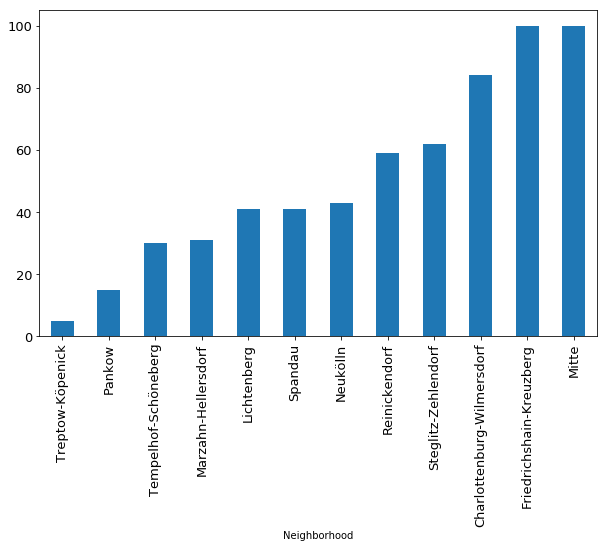

In [27]:
berlin_venues.groupby('Neighborhood').size().sort_values().plot(kind='bar',figsize=(10,6), fontsize=13)

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Let's make 10 venues for each borough (bezirke) and create a dataframe for them

In [29]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NeighborhoodName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['NeighborhoodName'] = berlin_grouped['NeighborhoodName']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg-Wilmersdorf,Hotel,Italian Restaurant,Plaza,Café,German Restaurant,Boarding House,Lake,Light Rail Station,Steakhouse,Supermarket
1,Friedrichshain-Kreuzberg,German Restaurant,Café,Bar,Coffee Shop,Italian Restaurant,Cocktail Bar,Bakery,Wine Bar,Beer Bar,Ice Cream Shop
2,Lichtenberg,Tram Station,Furniture / Home Store,Supermarket,Music Venue,Drugstore,Automotive Shop,Hardware Store,Chinese Restaurant,Motorcycle Shop,Cafeteria
3,Marzahn-Hellersdorf,Supermarket,Drugstore,Bus Stop,Hotel,Plaza,Ice Cream Shop,Train,Diner,Light Rail Station,Trail
4,Mitte,Hotel,Coffee Shop,Café,Bar,Gym / Fitness Center,Science Museum,Vegetarian / Vegan Restaurant,Beer Garden,Cocktail Bar,Dance Studio
5,Neukölln,Supermarket,Fast Food Restaurant,German Restaurant,Hotel,Clothing Store,History Museum,Electronics Store,Park,Sculpture Garden,Metro Station
6,Pankow,Supermarket,Light Rail Station,Café,Flower Shop,Hotel,Asian Restaurant,Gas Station,Bus Stop,Organic Grocery,Bakery
7,Reinickendorf,Café,Italian Restaurant,Restaurant,Drugstore,Clothing Store,Supermarket,Hotel,Ice Cream Shop,Indian Restaurant,German Restaurant
8,Spandau,Supermarket,Pizza Place,Bus Stop,Restaurant,Hardware Store,Drugstore,Park,Clothing Store,Chinese Restaurant,Café
9,Steglitz-Zehlendorf,Italian Restaurant,Café,German Restaurant,Doner Restaurant,Bus Stop,Plaza,Gourmet Shop,Steakhouse,Supermarket,Chocolate Shop


### Cluster Neighborhoods with k-means - lets find the best k

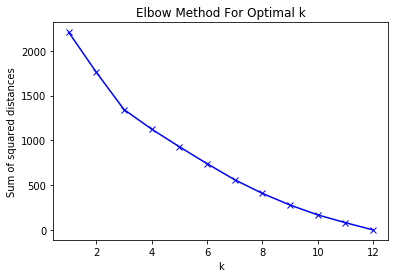

In [31]:
X = berlin_grouped.drop('NeighborhoodName', 1).astype(float)
X = StandardScaler().fit_transform(X)
sum_of_squared_distances = []
K = range(1,13)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### The optimal k is 3 (could be also 4 but 3 seems better)

In [32]:
kclusters = 3
X = berlin_grouped.drop('NeighborhoodName', 1).astype(float)
X = StandardScaler().fit_transform(X)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 0, 0, 2, 0, 0, 0, 0, 0])

### Let's merge cluster labels and venues

In [33]:
# dataframe that includes the cluster as well as the top 10 venues for each neighborhood
berlin_merged = berlin_df

# add clustering labels
berlin_merged['Cluster Labels'] = kmeans.labels_

berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('NeighborhoodName'), on='Borough')
berlin_merged.head()

,ID,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,01,Mitte,52.532895,13.365970,0,Hotel,Coffee Shop,Café,Bar,Gym / Fitness Center,Science Museum,Vegetarian / Vegan Restaurant,Beer Garden,Cocktail Bar,Dance Studio
1,02,Friedrichshain-Kreuzberg,52.503811,13.428234,1,German Restaurant,Café,Bar,Coffee Shop,Italian Restaurant,Cocktail Bar,Bakery,Wine Bar,Beer Bar,Ice Cream Shop
2,03,Pankow,52.597229,13.440279,0,Supermarket,Light Rail Station,Café,Flower Shop,Hotel,Asian Restaurant,Gas Station,Bus Stop,Organic Grocery,Bakery
3,04,Charlottenburg-Wilmersdorf,52.501039,13.270249,0,Hotel,Italian Restaurant,Plaza,Café,German Restaurant,Boarding House,Lake,Light Rail Station,Steakhouse,Supermarket
4,05,Spandau,52.525791,13.178819,2,Supermarket,Pizza Place,Bus Stop,Restaurant,Hardware Store,Drugstore,Park,Clothing Store,Chinese Restaurant,Café


In [34]:
berlin_merged['Cluster Labels'].values

array([0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0])

### Let's examine clusters

In [35]:
# Cluster #0
berlin_merged[berlin_merged['Cluster Labels'] == 0]

,ID,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,01,Mitte,52.532895,13.365970,0,Hotel,Coffee Shop,Café,Bar,Gym / Fitness Center,Science Museum,Vegetarian / Vegan Restaurant,Beer Garden,Cocktail Bar,Dance Studio
2,03,Pankow,52.597229,13.440279,0,Supermarket,Light Rail Station,Café,Flower Shop,Hotel,Asian Restaurant,Gas Station,Bus Stop,Organic Grocery,Bakery
3,04,Charlottenburg-Wilmersdorf,52.501039,13.270249,0,Hotel,Italian Restaurant,Plaza,Café,German Restaurant,Boarding House,Lake,Light Rail Station,Steakhouse,Supermarket
5,06,Steglitz-Zehlendorf,52.434843,13.239075,0,Italian Restaurant,Café,German Restaurant,Doner Restaurant,Bus Stop,Plaza,Gourmet Shop,Steakhouse,Supermarket,Chocolate Shop
6,07,Tempelhof-Schöneberg,52.441117,13.380739,0,Supermarket,Gym / Fitness Center,Industrial Estate,Pet Store,Racetrack,Chinese Restaurant,Pool,Climbing Gym,Ice Cream Shop,Comedy Club
7,08,Neukölln,52.441082,13.454965,0,Supermarket,Fast Food Restaurant,German Restaurant,Hotel,Clothing Store,History Museum,Electronics Store,Park,Sculpture Garden,Metro Station
8,09,Treptow-Köpenick,52.429583,13.611210,0,Pier,Post Office,Beer Garden,Bus Stop,Boat Rental,Cultural Center,Electronics Store,Food Court,Food & Drink Shop,Flower Shop
9,10,Marzahn-Hellersdorf,52.521121,13.578832,0,Supermarket,Drugstore,Bus Stop,Hotel,Plaza,Ice Cream Shop,Train,Diner,Light Rail Station,Trail
10,11,Lichtenberg,52.534910,13.509767,0,Tram Station,Furniture / Home Store,Supermarket,Music Venue,Drugstore,Automotive Shop,Hardware Store,Chinese Restaurant,Motorcycle Shop,Cafeteria
11,12,Reinickendorf,52.595674,13.291344,0,Café,Italian Restaurant,Restaurant,Drugstore,Clothing Store,Supermarket,Hotel,Ice Cream Shop,Indian Restaurant,German Restaurant


In [36]:
# Cluster #1
berlin_merged[berlin_merged['Cluster Labels'] == 1]

,ID,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,02,Friedrichshain-Kreuzberg,52.503811,13.428234,1,German Restaurant,Café,Bar,Coffee Shop,Italian Restaurant,Cocktail Bar,Bakery,Wine Bar,Beer Bar,Ice Cream Shop


In [37]:
# Cluster #2
berlin_merged[berlin_merged['Cluster Labels'] == 2]

,ID,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,05,Spandau,52.525791,13.178819,2,Supermarket,Pizza Place,Bus Stop,Restaurant,Hardware Store,Drugstore,Park,Clothing Store,Chinese Restaurant,Café


### Top 10 venues for each cluster
Let's give names and descriptions to clusters

In [38]:
for i in range(kclusters):
    print("Cluster",i, ', '.join(berlin_merged[berlin_merged['Cluster Labels'] == i].iloc[:,5:15].values.tolist()[0]))

Cluster 0 Hotel, Coffee Shop, Café, Bar, Gym / Fitness Center, Science Museum, Vegetarian / Vegan Restaurant, Beer Garden, Cocktail Bar, Dance Studio
Cluster 1 German Restaurant, Café, Bar, Coffee Shop, Italian Restaurant, Cocktail Bar, Bakery, Wine Bar, Beer Bar, Ice Cream Shop
Cluster 2 Supermarket, Pizza Place, Bus Stop, Restaurant, Hardware Store, Drugstore, Park, Clothing Store, Chinese Restaurant, Café


#### Let's make cluster descriptions for maps popup

In [39]:
cluster_desc = {}
cluster_desc[0] = "Hotel, Coffee Shop, Café, Bar, Gym / Fitness Center, Science Museum, Vegetarian / Vegan Restaurant, Beer Garden, Cocktail Bar, Dance Studio"
cluster_desc[1] = "German Restaurant, Café, Bar, Coffee Shop, Italian Restaurant, Cocktail Bar, Bakery, Wine Bar, Beer Bar, Ice Cream Shop"
cluster_desc[2] = "Supermarket, Pizza Place, Bus Stop, Restaurant, Hardware Store, Drugstore, Park, Clothing Store, Chinese Restaurant, Café"

## Visualizing the resulting clusters
We'll show boroughs (bezirken) marked with rental indexes

In [40]:
berlin_geo = r'berlin-bezirksgrenzen.geojson'

# create map
colors = [
    'green',
    'orange',
    'purple',
    'yellow',
    'red'
]
    
map_clusters = folium.Map(location=[berlin_coords[0], berlin_coords[1]], zoom_start=11)


map_clusters.choropleth(
    geo_data=berlin_geo,
    key_on='feature.properties.Gemeinde_name',
    data=berlin_apartments_rentals_df,
    columns=["Borough", "AvgPrice_€m2"],
    fill_color='YlGnBu',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average rents in Berlin in Euro per square meter'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Borough'], berlin_merged['Cluster Labels']):
    txt = str(poi) + ' - Cluster ' + str(cluster) + ' - ' + str(cluster_desc[cluster])
    label = folium.Popup(txt, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### Conclusion

With prices close to Berlin average, close to center and with vibrant social events and venues for younger people, *Friedrichshain-Kreuzberg* seems to be the best candidate to rent a flat. 

In [41]:
berlin_merged[berlin_merged['Borough'] == 'Friedrichshain-Kreuzberg']

,ID,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,02,Friedrichshain-Kreuzberg,52.503811,13.428234,1,German Restaurant,Café,Bar,Coffee Shop,Italian Restaurant,Cocktail Bar,Bakery,Wine Bar,Beer Bar,Ice Cream Shop


In [42]:
berlin_apartments_rentals_df[berlin_apartments_rentals_df["Borough"]=='Friedrichshain-Kreuzberg']

,Borough,AvgPrice_€m2
1,Friedrichshain-Kreuzberg,14.89


In [43]:
rents_berlin_2019_df2 = rents_berlin_2019_df.drop('Germany', 1)
rents_berlin_2019_df2

,square_m,Berlin
0,30,13.80
1,60,11.46
2,100,13.07
